In [1]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

c:\users\hp pavilion\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
traindata=pd.read_csv('traindata_gray.csv')
traindata=traindata.drop(['Unnamed: 0'],axis=1)
labeldata=pd.read_csv('labeldata_gray.csv')
labeldata=labeldata.drop(['Unnamed: 0'],axis=1)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(traindata,labeldata, test_size=0.20, random_state=200)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_test=X_test.as_matrix()
Y_test=Y_test.as_matrix()

X_test_batch=np.vsplit(X_test,20)
Y_test_batch=np.vsplit(Y_test,20)

for i in range(0,20):
    X_test_batch[i]=X_test_batch[i].reshape(100,128,72,1)   
    
print(X_test_batch[3].shape)
print(Y_test_batch[3].shape)    

(8000, 9216)
(8000, 2)
(2000, 9216)
(2000, 2)
(100, 128, 72, 1)
(100, 2)


In [4]:
#again accuracy calculated to assure model is loaded correctly and successfully

learning_rate = 0.0001
n_classes = 2
weights_updated  = {
    'wc1_updated': tf.Variable(tf.random_normal([5, 5, 1, 32],mean=0.0,stddev=1.0),name='wc1_updated'),
    'wc2_updated': tf.Variable(tf.random_normal([5, 5, 32, 64],mean=0.0,stddev=1.0),name='wc2_updated'),
    'wd1_updated': tf.Variable(tf.random_normal([32*18*64, 1024],mean=0.0,stddev=1.0),name='wd1_updated'),
    'w_out_updated': tf.Variable(tf.random_normal([1024, n_classes],mean=0.0,stddev=1.0),name='w_out_updated')}

biases_updated = {
    'bc1_updated': tf.Variable(tf.random_normal([32]),name='bc1_updated'),
    'bc2_updated': tf.Variable(tf.random_normal([64]),name='bc2_updated'),
    'bd1_updated': tf.Variable(tf.random_normal([1024]),name='bd1_updated'),
    'b_out_updated': tf.Variable(tf.random_normal([n_classes]),name='b_out_updated')}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Layer 1 - 128*72*1 to 64*36*32
    conv1 = conv2d(x, weights_updated['wc1_updated'], biases_updated['bc1_updated'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 64*36*32 to 32*18*64
    conv2 = conv2d(conv1, weights_updated['wc2_updated'], biases_updated['bc2_updated'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Fully connected layer - 32*18*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights_updated['wd1_updated'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights_updated['wd1_updated']), biases_updated['bd1_updated'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 2
    out = tf.add(tf.matmul(fc1, weights_updated['w_out_updated']), biases_updated['b_out_updated'])
    out=tf.nn.softmax(out)
    return out

# tf Graph input
x = tf.placeholder(tf.float32, [None,128,72,1])
y = tf.placeholder(tf.float32, [None,n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model--output for each image
logits = conv_net(x, weights_updated, biases_updated, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

saver = tf.train.Saver()
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "model/my_model")
        
    test_acc_array=np.array([])
        
    for i in range(0,20) :
            batch_x_test = X_test_batch[i]
            batch_y_test = Y_test_batch[i]
            
            test_acc = sess.run(accuracy, feed_dict={
              x:batch_x_test,
              y:batch_y_test,
              keep_prob: 1.0})
            
            test_acc_array=np.append(test_acc_array,test_acc,axis=None)
    
    print('Testing Accuracy : {}'.format(np.mean(test_acc_array)))

Testing Accuracy : 0.9735000103712081


In [ ]:
#Now as we have loaded model now we will predict images in following code for batch number 4 for the sake of visualization
#and show the effectiveness of model in prediction.

#100 images as stored in our data file after preprocessing along with its prediction are given below in which 98 are correct
#out of 100 predictions.

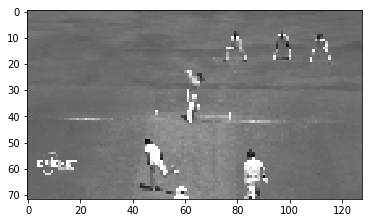

Image predicted is Cricket and originally image is  Cricket


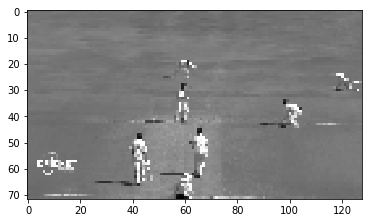

Image predicted is Cricket and originally image is  Cricket


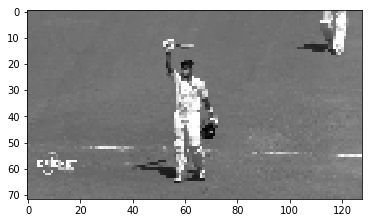

Image predicted is Cricket and originally image is  Cricket


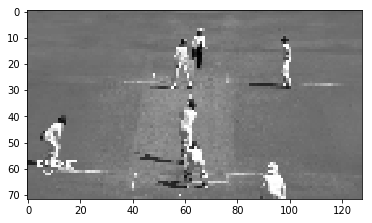

Image predicted is Cricket and originally image is  Cricket


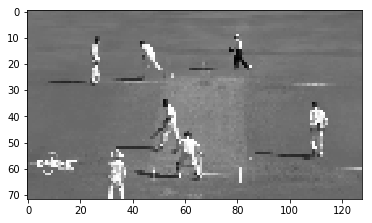

Image predicted is Cricket and originally image is  Cricket


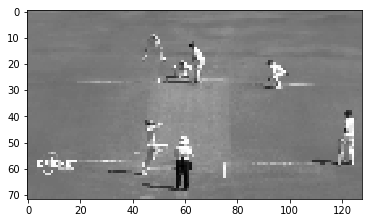

Image predicted is Cricket and originally image is  Cricket


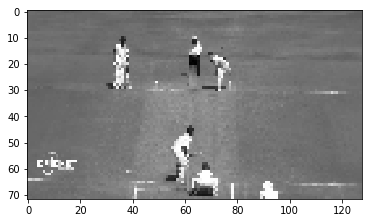

Image predicted is Cricket and originally image is  Cricket


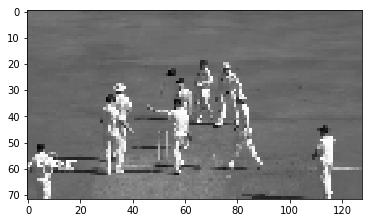

Image predicted is Cricket and originally image is  Cricket


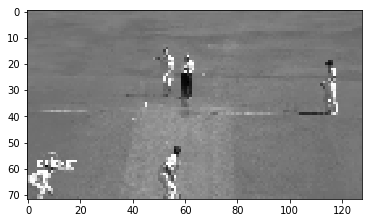

Image predicted is Cricket and originally image is  Cricket


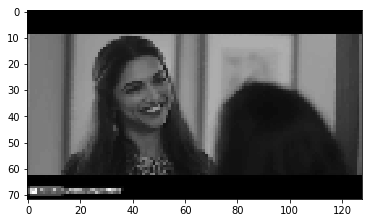

Image predicted is Advertisement and originally image is  Advertisement


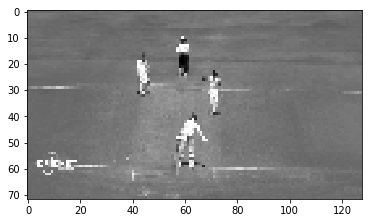

Image predicted is Cricket and originally image is  Cricket


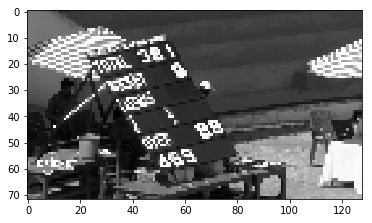

Image predicted is Cricket and originally image is  Cricket


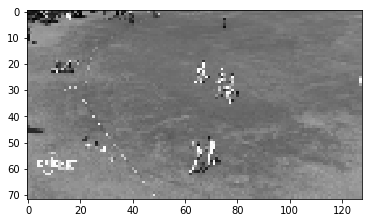

Image predicted is Cricket and originally image is  Cricket


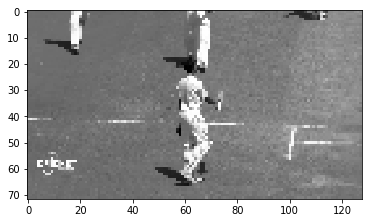

Image predicted is Cricket and originally image is  Cricket


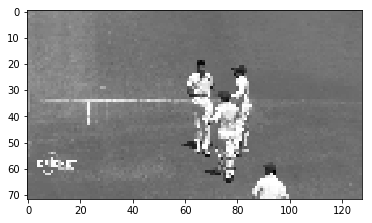

Image predicted is Cricket and originally image is  Cricket


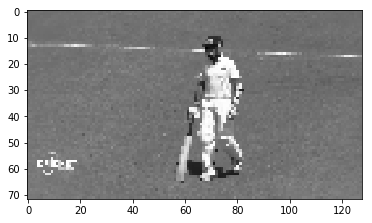

Image predicted is Cricket and originally image is  Cricket


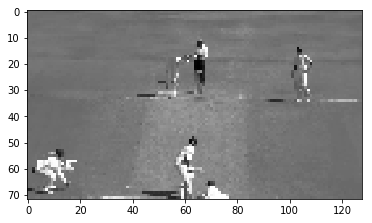

Image predicted is Cricket and originally image is  Cricket


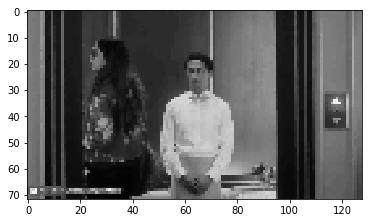

Image predicted is Cricket and originally image is  Advertisement


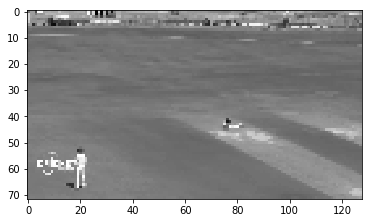

Image predicted is Cricket and originally image is  Cricket


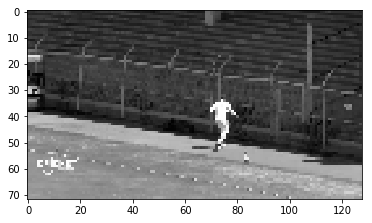

Image predicted is Cricket and originally image is  Cricket


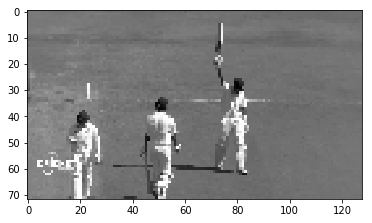

Image predicted is Cricket and originally image is  Cricket


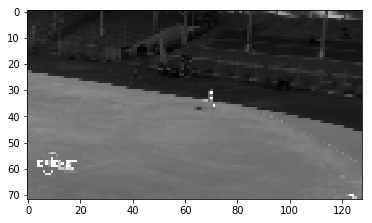

Image predicted is Cricket and originally image is  Cricket


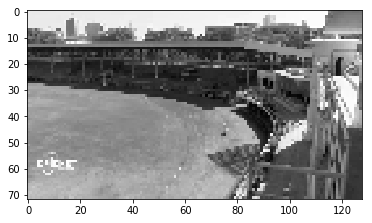

Image predicted is Cricket and originally image is  Cricket


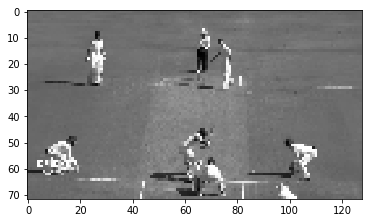

Image predicted is Cricket and originally image is  Cricket


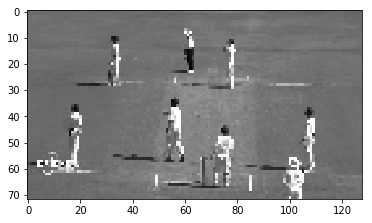

Image predicted is Cricket and originally image is  Cricket


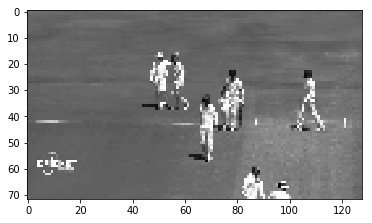

Image predicted is Cricket and originally image is  Cricket


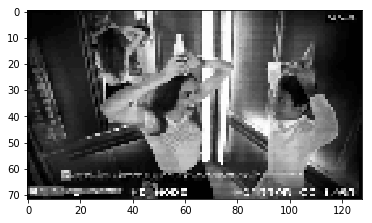

Image predicted is Advertisement and originally image is  Advertisement


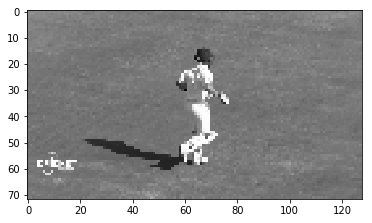

Image predicted is Cricket and originally image is  Cricket


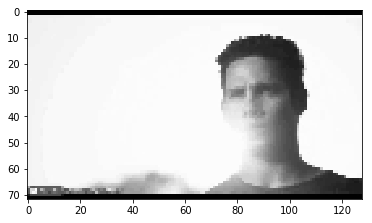

Image predicted is Advertisement and originally image is  Advertisement


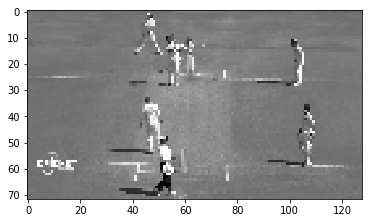

Image predicted is Cricket and originally image is  Cricket


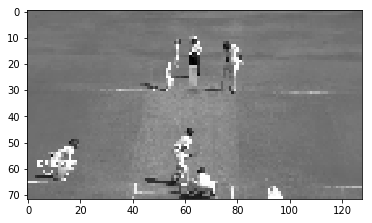

Image predicted is Cricket and originally image is  Cricket


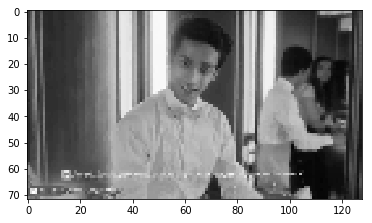

Image predicted is Advertisement and originally image is  Advertisement


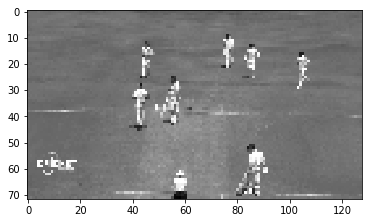

Image predicted is Cricket and originally image is  Cricket


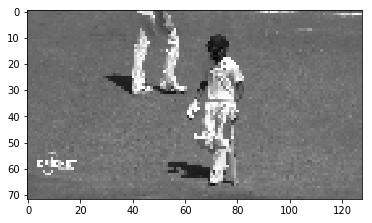

Image predicted is Cricket and originally image is  Cricket


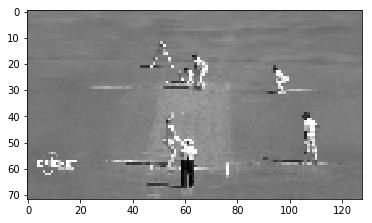

Image predicted is Cricket and originally image is  Cricket


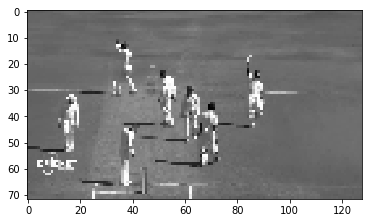

Image predicted is Cricket and originally image is  Cricket


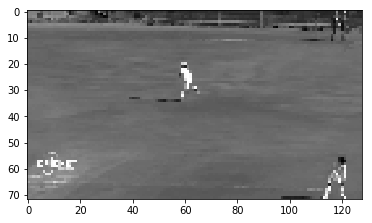

Image predicted is Cricket and originally image is  Cricket


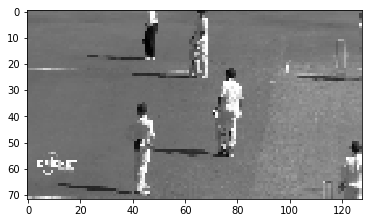

Image predicted is Cricket and originally image is  Cricket


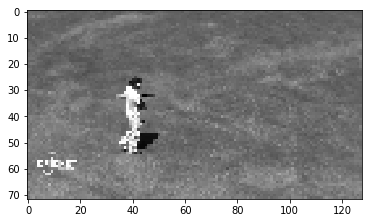

Image predicted is Cricket and originally image is  Cricket


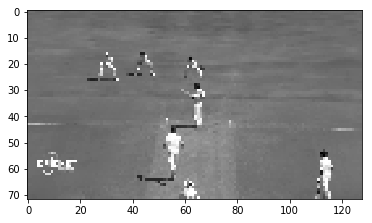

Image predicted is Cricket and originally image is  Cricket


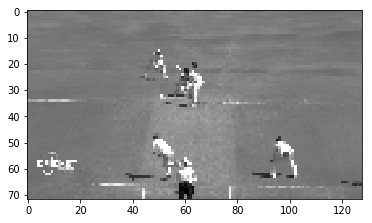

Image predicted is Cricket and originally image is  Cricket


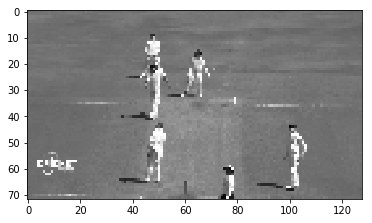

Image predicted is Cricket and originally image is  Cricket


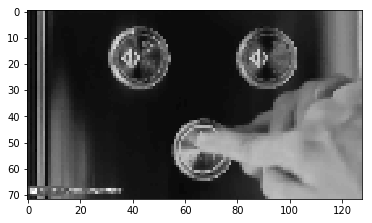

Image predicted is Advertisement and originally image is  Advertisement


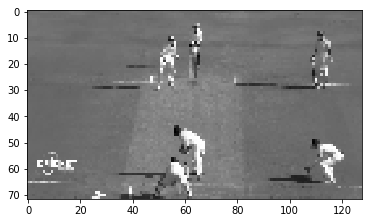

Image predicted is Cricket and originally image is  Cricket


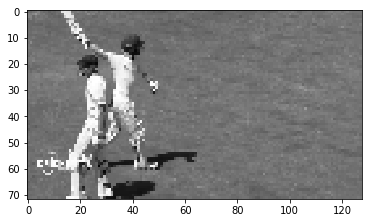

Image predicted is Cricket and originally image is  Cricket


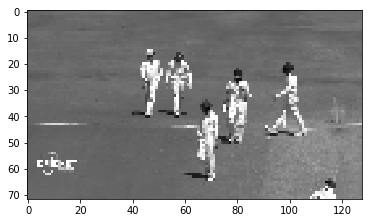

Image predicted is Cricket and originally image is  Cricket


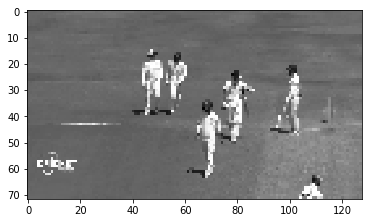

Image predicted is Cricket and originally image is  Cricket


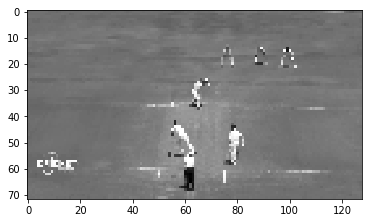

Image predicted is Cricket and originally image is  Cricket


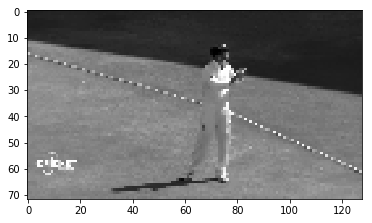

Image predicted is Cricket and originally image is  Cricket


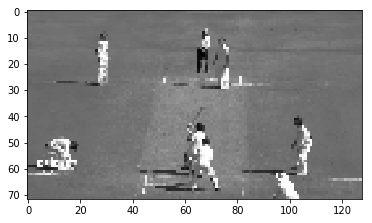

Image predicted is Cricket and originally image is  Cricket


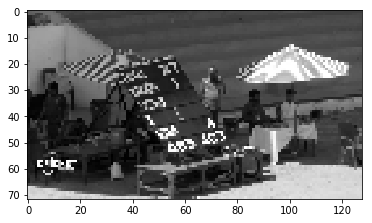

Image predicted is Cricket and originally image is  Cricket


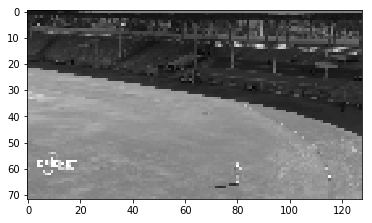

Image predicted is Cricket and originally image is  Cricket


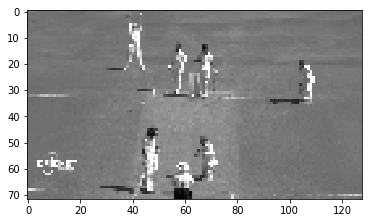

Image predicted is Cricket and originally image is  Cricket


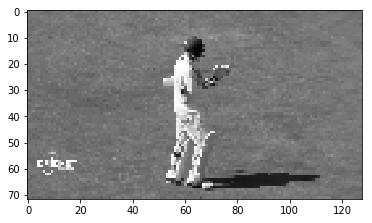

Image predicted is Cricket and originally image is  Cricket


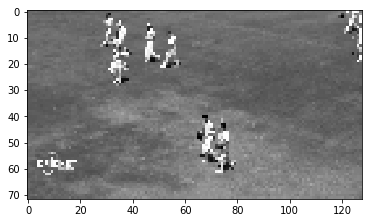

Image predicted is Cricket and originally image is  Cricket


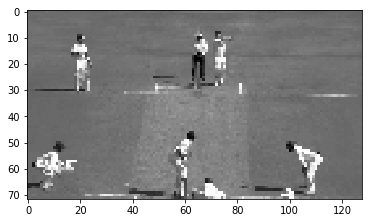

Image predicted is Cricket and originally image is  Cricket


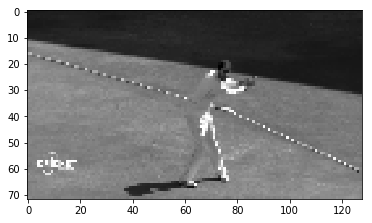

Image predicted is Cricket and originally image is  Cricket


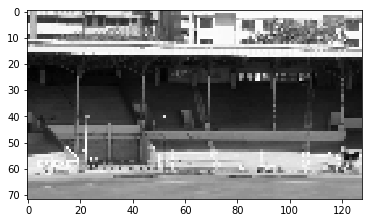

Image predicted is Cricket and originally image is  Cricket


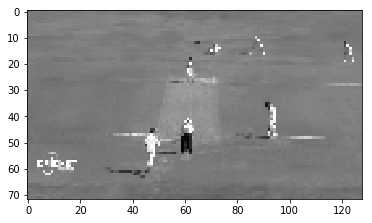

Image predicted is Cricket and originally image is  Cricket


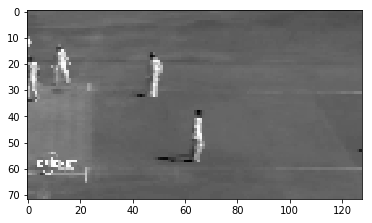

Image predicted is Cricket and originally image is  Cricket


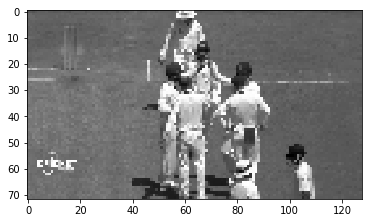

Image predicted is Cricket and originally image is  Cricket


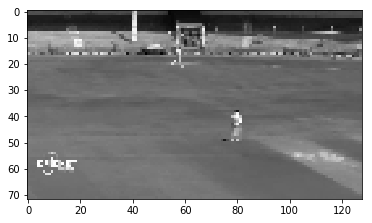

Image predicted is Cricket and originally image is  Cricket


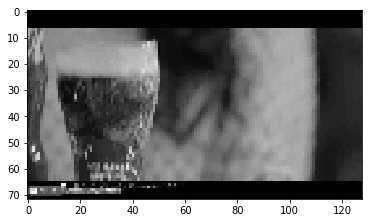

Image predicted is Advertisement and originally image is  Advertisement


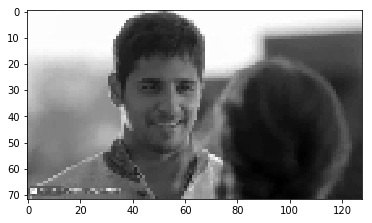

Image predicted is Advertisement and originally image is  Advertisement


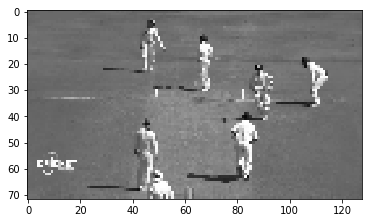

Image predicted is Cricket and originally image is  Cricket


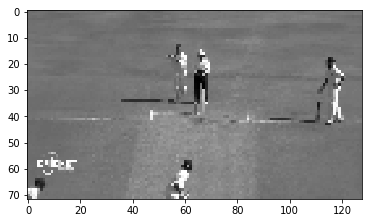

Image predicted is Cricket and originally image is  Cricket


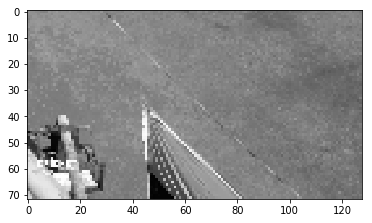

Image predicted is Cricket and originally image is  Cricket


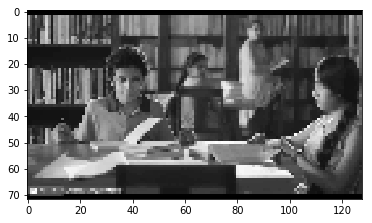

Image predicted is Advertisement and originally image is  Advertisement


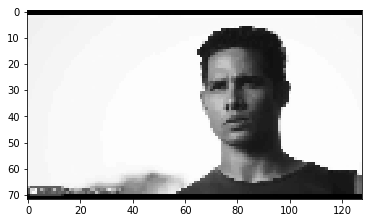

Image predicted is Advertisement and originally image is  Advertisement


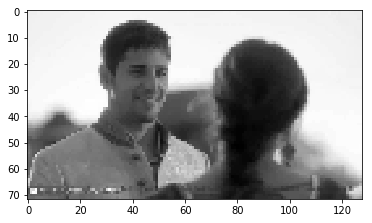

Image predicted is Advertisement and originally image is  Advertisement


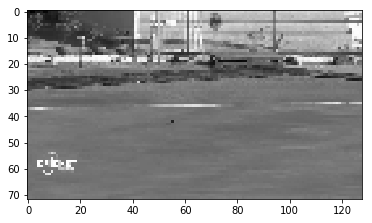

Image predicted is Cricket and originally image is  Cricket


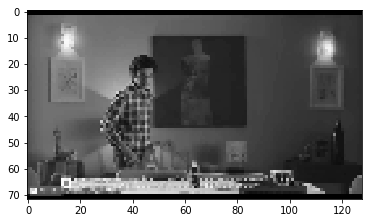

Image predicted is Advertisement and originally image is  Advertisement


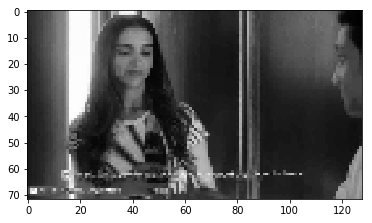

Image predicted is Advertisement and originally image is  Advertisement


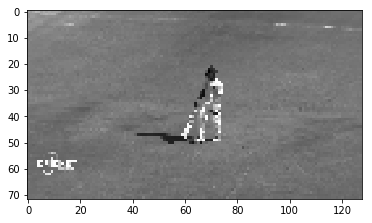

Image predicted is Cricket and originally image is  Cricket


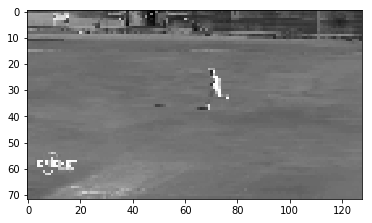

Image predicted is Cricket and originally image is  Cricket


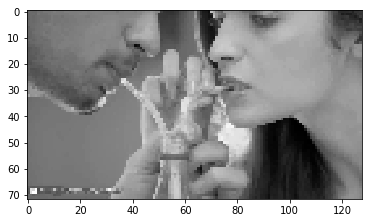

Image predicted is Cricket and originally image is  Advertisement


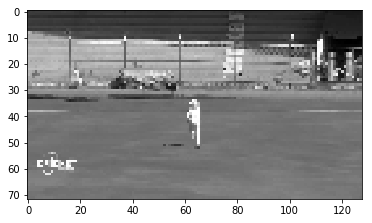

Image predicted is Cricket and originally image is  Cricket


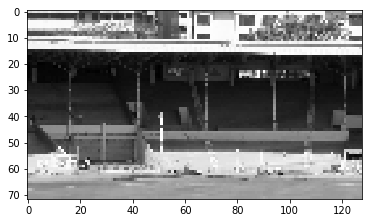

Image predicted is Cricket and originally image is  Cricket


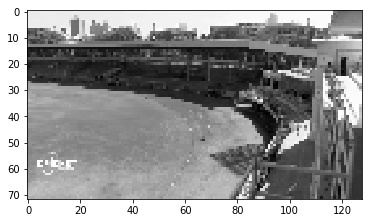

Image predicted is Cricket and originally image is  Cricket


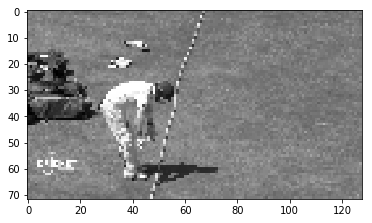

Image predicted is Cricket and originally image is  Cricket


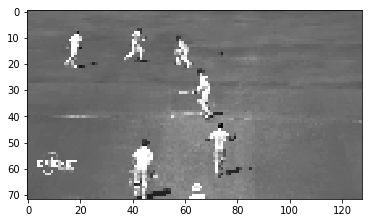

Image predicted is Cricket and originally image is  Cricket


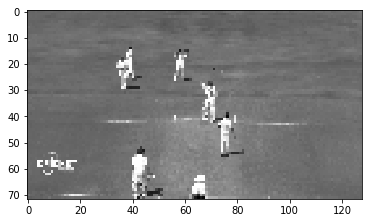

Image predicted is Cricket and originally image is  Cricket


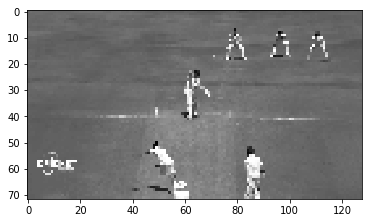

Image predicted is Cricket and originally image is  Cricket


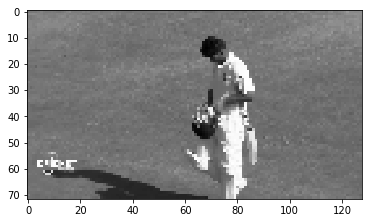

Image predicted is Cricket and originally image is  Cricket


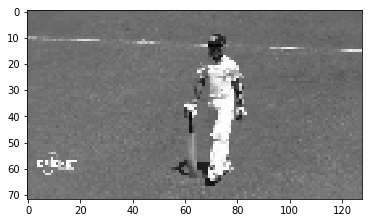

Image predicted is Cricket and originally image is  Cricket


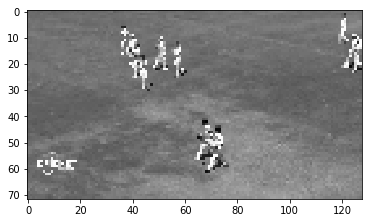

Image predicted is Cricket and originally image is  Cricket


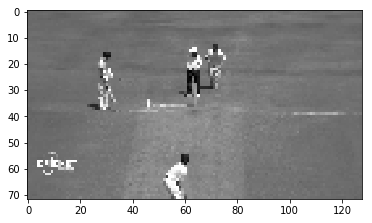

Image predicted is Cricket and originally image is  Cricket


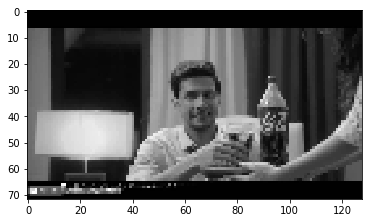

Image predicted is Advertisement and originally image is  Advertisement


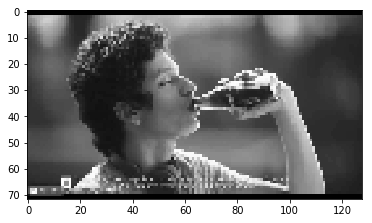

Image predicted is Advertisement and originally image is  Advertisement


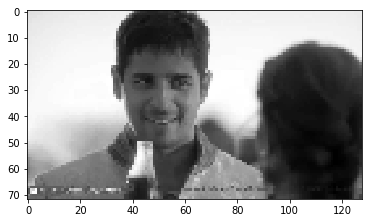

Image predicted is Advertisement and originally image is  Advertisement


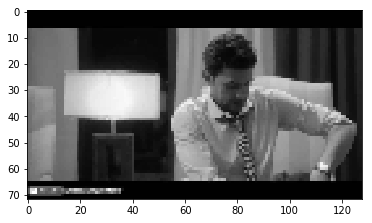

Image predicted is Advertisement and originally image is  Advertisement


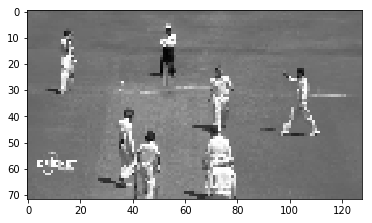

Image predicted is Cricket and originally image is  Cricket


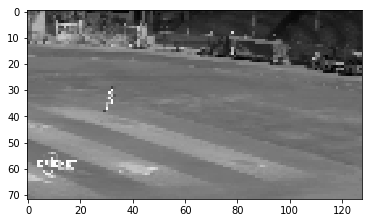

Image predicted is Cricket and originally image is  Cricket


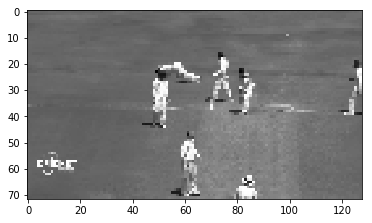

Image predicted is Cricket and originally image is  Cricket


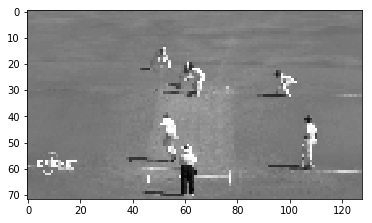

Image predicted is Cricket and originally image is  Cricket


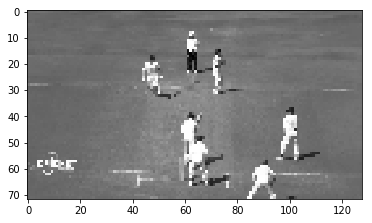

Image predicted is Cricket and originally image is  Cricket


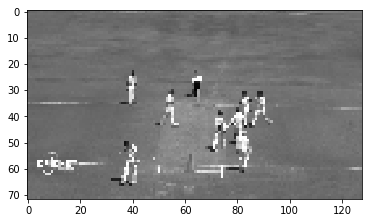

Image predicted is Cricket and originally image is  Cricket


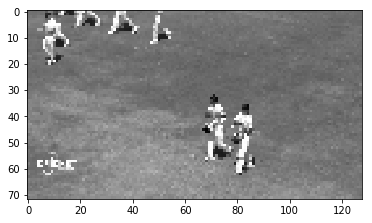

Image predicted is Cricket and originally image is  Cricket


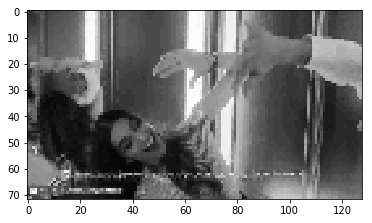

Image predicted is Advertisement and originally image is  Advertisement


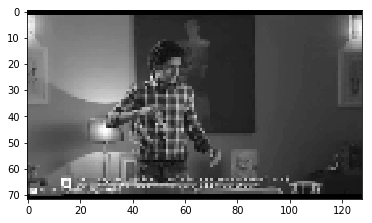

Image predicted is Advertisement and originally image is  Advertisement
Total number of correct predictions out of 100 are : 98


In [5]:
keep_prob=1.0
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "model/my_model")
        
    test_acc_x=tf.cast(X_test_batch[3],tf.float32)
    test_acc_y=Y_test_batch[3]
    test_acc_x_show=X_test_batch[3]
    
    logits = conv_net(test_acc_x, weights_updated, biases_updated, keep_prob)
    logits_display=sess.run(logits)
    
    count=0
    for i in range(0,100):
        
        im=test_acc_x_show[i].reshape(72,128)
        im=np.multiply(im,255)
        plt.imshow(im, cmap='gray')
        plt.show()
        
        labels=test_acc_y[i]
        
        if(labels[0]==1):
            label_original="Advertisement"
        if(labels[1]==1):
            label_original="Cricket"
        
        if(logits_display[i][0]==1):
            print("Image predicted is Advertisement and originally image is ",label_original)
        if(logits_display[i][1]==1):
            print("Image predicted is Cricket and originally image is ",label_original)
        if(logits_display[i][0]==1 and labels[0]==1):
            count=count+1
        if(logits_display[i][1]==1 and labels[1]==1):
            count=count+1    
    print("Total number of correct predictions out of 100 are :",count)   

In [5]:
#confusion matrix is designed for all the 2000 predictions on the testing data

keep_prob=1.0
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "model/my_model")
        
    pred_label=np.array([[0,1]])
    #array of actual labels
    true_label=Y_test
    for i in range(0,20) :
            
            batch_x_test = X_test_batch[i]  
            
            batch_x_test=tf.cast(batch_x_test,tf.float32)
            #predicting label for each test data
            logits = conv_net(batch_x_test, weights_updated, biases_updated, keep_prob)
            logits_display=sess.run(logits)
            logits_display=np.array(logits_display)
            #each prediction concatenated
            pred_label=np.concatenate((pred_label,logits_display),axis=0)
    
    #array of predicted labels
    pred_label=pred_label[1:]
    pred_label=pred_label.astype(np.int64)
   
    matrix_mul=[0,1]
    #matrix multiplied to make label array 1-d to feed into crosstab function
    pl=np.matmul(pred_label,matrix_mul).astype(np.int64)
    al=np.matmul(true_label,matrix_mul).astype(np.int64)
    
    al = pd.Series(al, name='Actual')
    pl = pd.Series(pl, name='Predicted')
    #confusuion matrix constructed
    df_confusion = pd.crosstab(al, pl)
    
    print(df_confusion)
    print(" ")
    print("Here Label 0 correspond to advertisement")
    print("Here Label 1 correspond to cricket ")

Predicted    0     1
Actual              
0          344    48
1            5  1603
 
Here Label 0 correspond to advertisement
Here Label 1 correspond to cricket 


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

recall=recall_score(true_label,pred_label,average=None)
precision=precision_score(true_label,pred_label,average=None)

print("Precision for label 0(Advertisement) and 1(Cricket) respectively is : ",precision)
print("Recall for label 0(Advertisement) and 1(Cricket) respectively is : ",recall)

Precision for label 0(Advertisement) and 1(Cricket) respectively is :  [ 0.99130435  0.97092671]
Recall for label 0(Advertisement) and 1(Cricket) respectively is :  [ 0.87244898  0.99689055]
